https://nsidc.org/data/nsidc-0720/versions/1#anchor-data-access-tools

https://www.npolar.no/quantarctica/#toggle-id-15

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import raster_tools as rt

import cartopy.crs as ccrs

##### Load Data

In [4]:
# Load lakes
lakes2 = gpd.read_file('data/Quantarctica3/Quantarctica3/Glaciology/Subglacial Lakes/SubglacialLakes_WrightSiegert.shp')
# regex replace spaces in LENGTH_M column
lakes2['LENGTH_M'] = lakes2['LENGTH_M'].str.replace('28100 + 4000', '28100')
lakes2['LENGTH_M'] = lakes2['LENGTH_M'].str.replace('<', '')
lakes2['LENGTH_M'] = lakes2['LENGTH_M'].str.replace(' ', '')
lakes2['LENGTH_M'] = pd.to_numeric(lakes2['LENGTH_M'], errors='coerce')
# make a new col claled SAT_DETECT with a value of 1 if the lake is detected by satellite (CLASS G) and 0 otherwise
lakes2['SAT_DETECT'] = np.where(lakes2['CLASS'] == 'G', 1, 0)

In [3]:
# load ice boundaries
ice_bounds = gpd.read_file('data/Quantarctica3/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/IceBoundaries_Antarctica_v2.shp')

In [4]:
# load flow speed
ice_vel_450 = rt.Raster('data/Quantarctica3/Quantarctica3/Glaciology/MEaSUREs Ice Flow Velocity/MEaSUREs_IceFlowSpeed_450m.tif')

In [5]:
# load DEM
dem = rt.Raster('data/dem/rema_mosaic_500m_v2.0_filled_cop30_dem.tif')

In [6]:
# get slope from dem
slope = rt.surface.slope(dem)

##### Plotting

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from raster_tools import Raster, open_dataset

import cartopy.crs as ccrs

def plot_with_basemap(title, rs=None, vector=None, vect_col=None, rs_cmap='gist_earth', vect_cmap='viridis', vmin=None, vmax=None, rs_mask=False, rs_log_scale=False):

    # Load basemap
    world = gpd.read_file('data/Quantarctica3/Quantarctica3/Miscellaneous/SimpleBasemap/ADD_DerivedLowresBasemap.shp')
    world = world.set_crs(epsg=3031)
    world = world.to_crs(epsg=3031)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})

    world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.5, color='blue')

    if rs_mask and rs is not None:
        rs = rt.clipping.mask(world, rs)

    if rs is not None:
        if vmin is None and vmax is None:
            rs.plot(ax=ax, cmap=rs_cmap, transform=ccrs.SouthPolarStereo(), alpha=0.7)
        else:
            rs.plot(ax=ax, cmap=rs_cmap, transform=ccrs.SouthPolarStereo(), alpha=0.7, vmin=vmin, vmax=vmax)

    if vector is not None:
        vector.plot(ax=ax, column=vect_col, cmap=vect_cmap, transform=ccrs.SouthPolarStereo(), legend=True, markersize=5)

    # Adjust map extent
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

    ax.set_title(title)
    plt.show()

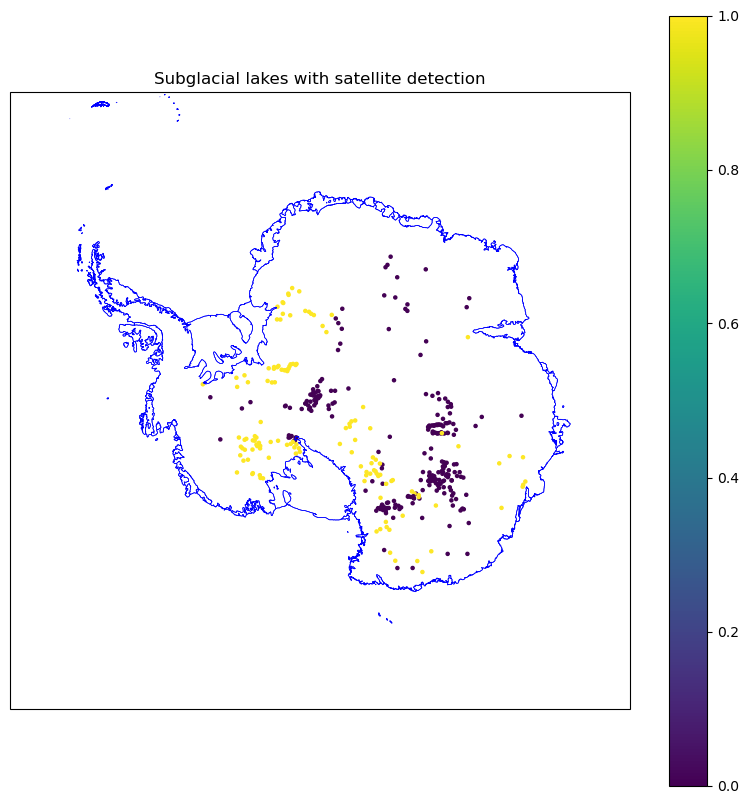

In [7]:
plot_with_basemap('Subglacial lakes with satellite detection',vector=lakes2, vect_col='SAT_DETECT', vect_cmap='viridis')

In [9]:
# plot_with_basemap('Ice boundaries',vector=ice_bounds, vect_col='Regions', vect_cmap='viridis')

In [10]:
# plot_with_basemap('Antarctic Slope',slope, rs_cmap='gist_earth', vmin=slope.min().compute(), vmax=slope.max().compute())

In [11]:
# log scale the slope for plotting
slope_log = np.log(slope + 1)
# slope_log.plot(cmap='gist_earth')

##### Zonal Stats

In [12]:
# create a 1km buffer around the lakes
# lakes2['geometry_buffer'] = lakes2.buffer(1000)

# get zonal states for the slope for all lakes
slope_zonal = rt.zonal.zonal_stats(lakes2, slope, stats=['mean', 'median', 'max', 'min'])

In [13]:
slope_zonal = slope_zonal.compute()
slope_zonal = slope_zonal['band_1']

c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\rasterio\features.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


In [14]:
slope_zonal['min'].sort_values(ascending=False)

zone
258    2.159162
278    1.563556
296    1.275975
317    1.064880
274    1.041516
         ...   
212         NaN
193         NaN
191         NaN
63          NaN
200         NaN
Name: min, Length: 379, dtype: float64

<Axes: xlabel='SAT_DETECT'>

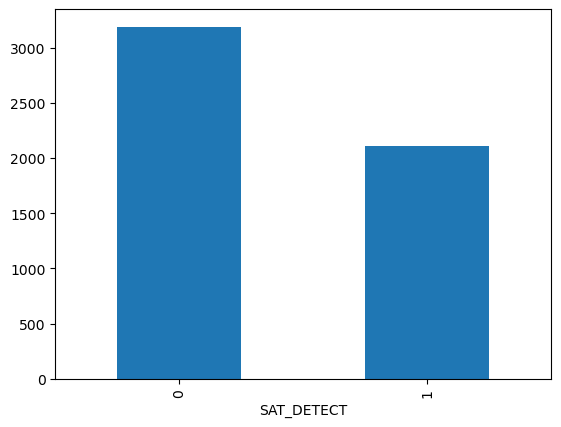

In [15]:
# plot average ICETHKNS_M vs CLASS
lakes2.groupby('SAT_DETECT')['ICETHKNS_M'].mean().plot(kind='bar')

In [16]:
# zonal stats for the lakes
zonal_stats = rt.zonal.zonal_stats(lakes2, dem, stats=['mean', 'max', 'min', 'std', 'median'])

In [17]:
zonal_stats.compute()

band_1                                           
             mean          max          min std       median
zone                                                        
348    291.671875   291.671875   291.671875 NaN   291.671875
70    1911.796875  1911.796875  1911.796875 NaN  1911.796875
60    1798.179688  1798.179688  1798.179688 NaN  1798.179688
316    380.187500   380.187500   380.187500 NaN   380.187500
240   1229.578125  1229.578125  1229.578125 NaN  1229.578125
...           ...          ...          ...  ..          ...
151   2752.164062  2752.164062  2752.164062 NaN  2752.164062
379    871.570312   871.570312   871.570312 NaN   871.570312
363   2217.820312  2217.820312  2217.820312 NaN  2217.820312
378    933.710938   933.710938   933.710938 NaN   933.710938
377   1052.968750  1052.968750  1052.968750 NaN  1052.968750

[379 rows x 5 columns]

##### Proximity raster

In [18]:
lakes_vector = rt.Vector(lakes2)

In [19]:
# rasterize the lakes
lakes_raster = rt.rasterize.rasterize(lakes_vector, dem, field='TALLY')

In [20]:
prox_raster = rt.distance.pa_proximity(lakes_raster, target_values=np.arange(1, 380).astype(int))

# Load basemap
world = gpd.read_file('data/Quantarctica3/Quantarctica3/Miscellaneous/SimpleBasemap/ADD_DerivedLowresBasemap.shp')
world.set_crs(epsg=3031, inplace=True)
world = world.to_crs(epsg=3031)

# clip prox raster to world
# prox_raster = prox_raster.clip(world.geometry)
prox_clipped = rt.clipping.clip(world, prox_raster)

Text(0.5, 1.0, 'Proximity to Subglacial Lakes')

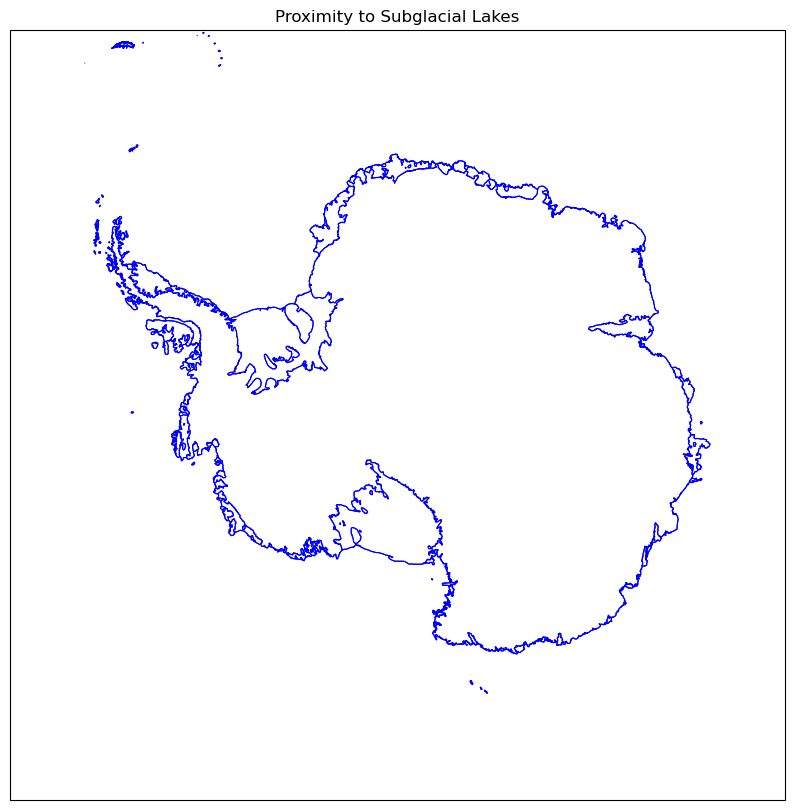

In [22]:
# Load Antarctic shapefile and transform to EPSG:3031
world = gpd.read_file('data/Quantarctica3/Quantarctica3/Miscellaneous/SimpleBasemap/ADD_DerivedLowresBasemap.shp')
world.set_crs(epsg=3031, inplace=True)
world = world.to_crs(epsg=3031)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.8, color='blue')

# prox_clipped.plot(ax=ax, cmap='gist_earth', transform=ccrs.SouthPolarStereo(), alpha=0.8)

# Adjust map extent
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

plt.title("Proximity to Subglacial Lakes")
# plt.show()

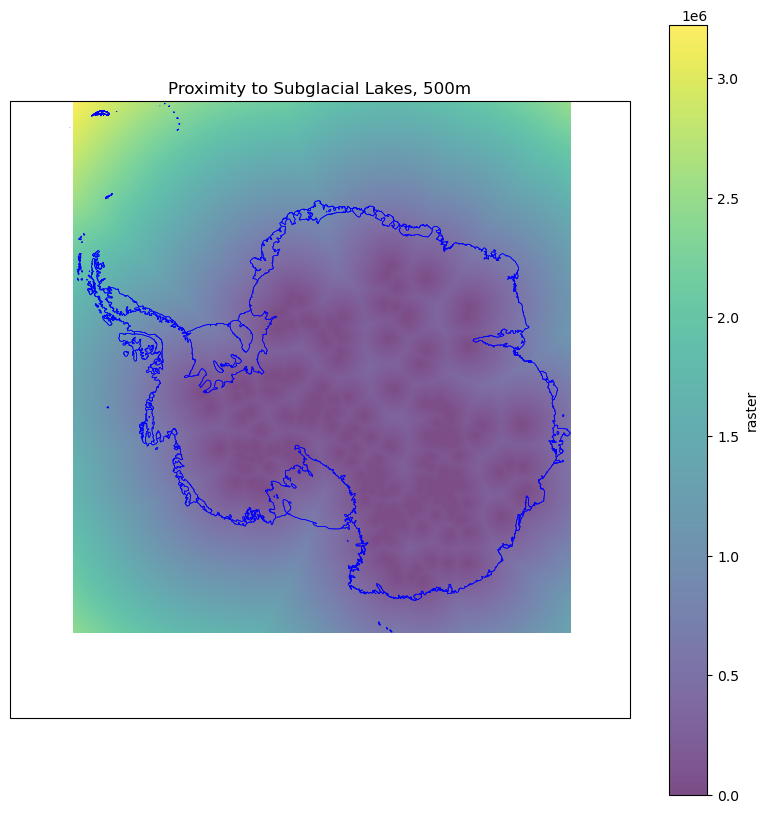

In [23]:
plot_with_basemap('Proximity to Subglacial Lakes, 500m', rs=prox_raster, rs_cmap='viridis', rs_mask=True)

------

##### Clustering

  File "c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\aster\anaconda3\envs\rstools39\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\aster\anaconda3\envs\rstools39\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\aster\anaconda3\envs\rstools39\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


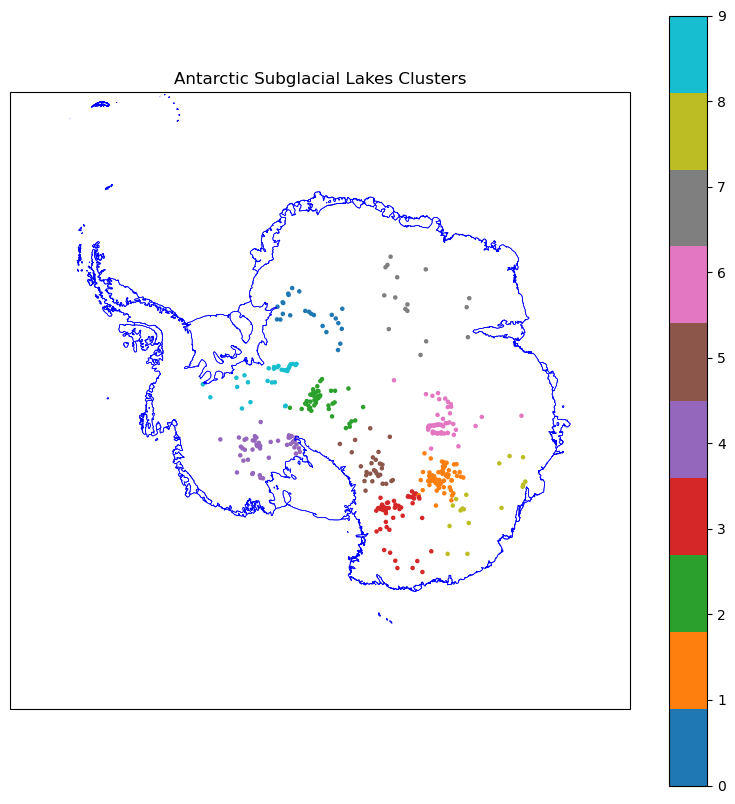

In [24]:
# we will cluster the lakes from lakes2 gdf using kmeans.  the goal is to create a new column in the gdf called 'CLUSTER' that will have the cluster number for each lake, then plot the clusters on the map
from sklearn.cluster import KMeans

# get the coordinates of the lakes
lakes2['X'] = lakes2.geometry.x
lakes2['Y'] = lakes2.geometry.y

# create a new df with only the coordinates
X = lakes2[['X', 'Y']]
# fit the kmeans model
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
# get the cluster labels
lakes2['CLUSTER'] = kmeans.labels_

# Plot
plot_with_basemap('Antarctic Subglacial Lakes Clusters',vector=lakes2, vect_col='CLUSTER', vect_cmap='tab10')